#**Ch7. 앙상블 학습과 랜덤 포레스트**


##**7.1 투표 기반 분류기**

로지스틱 회귀 분류기, SVM 분류기, 랜덤 포레스트 분류기, K-최근접 이웃 분류기 등 훈련

- 직접 투표(hard voting) : 다수결 투표로 정해지는 분류기
  - 다수결 투표 분류기가 앙상블에 포함된 개별 분류기 중 가자 뛰어난 것보다도 정확도가 높을 수 있음
  - 큰 수의 법칙 - 실험 반복할수록 확률 올라감
  - 모든 분류기가 완벽하게 독립적이고 오차에 상관관계가 없는 경우

In [1]:
#make_moons dataset
#마주보는 두 개의 반원 모양으로데이터 포인트가 놓여 있는 이진 분류를 위한 데이터셋
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X,y=make_moons(n_samples=100, noise=0.15)
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2)

In [2]:
# 투표 기반 분류기
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators = [('lr',log_clf),('rf',rnd_clf),('svc',svm_clf)], voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [3]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test,y_pred)) 

LogisticRegression 1.0
RandomForestClassifier 1.0
SVC 1.0
VotingClassifier 1.0


- 간접 투표(soft voting) : 모든 분류기가 클래스의 확률을 예측할 수 있는 경우 예측을 평균냄 (predict_proba()) 
  - 직접 투표 방식보다 성능이 높음
  - `voting = 'soft'`


##**7.2 배깅과 페이스팅**
같은 알고리즘을 사용하고 훈련 세트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습시키는 방법
- **배깅** : 훈련 세트에서 중복을 허용하여 샘플링
- **페이스팅** : 중복을 허용하지 않고 샘플링
- 예측
  - 분류 : 통계적 최빈값
  - 회귀 : 평균
- 동시에 다른 CPU 코어나 서버에서 병렬로 학습 가능하여 확장성 Good

###**7.2.1 사이킷런의 배깅과 페이스팅**
- `bootstrap = False` : 페이스팅
- `n_jobs` : 사이킷런이 훈련과 예측에 사용할 CPU 코어 수를 지정(-1: 모든 코어 사용)

In [4]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators = 500, max_samples = 50, bootstrap = True,n_jobs=-1
)
bag_clf.fit(X_train,y_train)
y_pred = bag_clf.predict(X_test)

###**7.2.2 oob 평가**
배깅을 사용하면 어떤 샘플은 여러 번 샘플링되고, 어떤 샘플은 전혀 선택되지 않을 수 있음
- 평균적으로 각 예측기에 훈련 샘플의 63%정도만 샘플링됨
- oob(out-of-bag) 샘플 : 선택되지 않은 훈련 샘플의 나머지 37%

In [5]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True
)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9625

In [6]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test,y_pred)

1.0

oob 샘플에 대한 결정 함수의 값
- 결정 함수는 각 훈련 샘플의 클래스 확률을 반환 : 기반 예측기가 predict_proba() 메서드를 가지고 있기 때문

In [7]:
bag_clf.oob_decision_function_

array([[0.86702128, 0.13297872],
       [0.88505747, 0.11494253],
       [0.92783505, 0.07216495],
       [0.00540541, 0.99459459],
       [0.99438202, 0.00561798],
       [0.9558011 , 0.0441989 ],
       [0.38918919, 0.61081081],
       [0.16666667, 0.83333333],
       [1.        , 0.        ],
       [0.97005988, 0.02994012],
       [0.98913043, 0.01086957],
       [0.10362694, 0.89637306],
       [1.        , 0.        ],
       [0.0952381 , 0.9047619 ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.01477833, 0.98522167],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.74479167, 0.25520833],
       [0.00534759, 0.99465241],
       [0.0802139 , 0.9197861 ],
       [0.89189189, 0.10810811],
       [0.31147541, 0.68852459],
       [0.10497238, 0.89502762],
       [0.98314607, 0.01685393],
       [1.        , 0.        ],
       [0.97660819, 0.02339181],
       [0.

##**7.3 랜덤 패치와 랜덤 서브스페이스**
랜덤 패치 방식 : 훈련 특성과 샘플을 모두 샘플링 하는 것

랜덤 서브스페이스 방식 : 훈련 샘플ㅇ르 모두 사용하고 특성은 샘플링
- bootstrap = False
- max_samples = 1.0
- bootstrap_features = True
- max_features < 1.0

##**7.4 랜덤 포레스트**
배깅 방법을 적용한 결정 트리의 앙상블

- max_samples : 훈련 세트의 크기
  - 정수 값을 입력하면 지정된 수만큼 선택
  - 0과 1 사이의 실수 값을 입력하면 지정된 비율만큼 선택
- BaggingClassifier의 매개변수를 모두 가지고 있음

In [8]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16, n_jobs = -1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [9]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features = 'auto', max_leaf_nodes =16), 
    n_estimators=500, max_samples=1.0,bootstrap=True,n_jobs=-1
)

###**7.4.1 엑스트라 트리**
랜덤포레스트에서 각 노드는 무작위로 특성의 서브셋을 만들어 분할에 사용

-> 트리를 더 무작위하게 만들기 위해 최적의 임곗값을 찾는 대신 후보 특성을 사용해 무작위 분할한 다음 최상의 분할을 선택

- 익스트림 랜덤 트리 앙상블(엑스트라 트리)
  - 편향이 늘어나고 분산이 줄어듦
  - 최적의 임곗값을 찾지 않아도 되어 엑스트라 트리가 훨씬 빠름
  - `ExtraTreesClassifier`

###**7.4.2 특성 중요도**
어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정

In [10]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500,n_jobs=-1)
rnd_clf.fit(iris['data'],iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
  print(name,score)

sepal length (cm) 0.09123219444900728
sepal width (cm) 0.024945210874102355
petal length (cm) 0.42820006939950406
petal width (cm) 0.4556225252773862


가장 중요한 특성은 꽃잎의 길이(44%)와 너비(42%)

##**7.5 부스팅**
부스팅 : 약한 학습기를 여러개 연결하여 강한 학습기를 만드는 앙상블 방법
- 에이다부스트, 그래디언트 부스팅

###**7.5.1 에이다부스트**
이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높임-> 가중치 업데이트 방식

In [ ]:
from sklean.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm='SAMME.R',learning_rate=0.5
)
ada_clf.fit(X_train,y_train)

###**7.5.2 그래디언트 부스팅**
이전 예측기가 만든 잔여 오차(residual error)에 새로운 예측기를 학습
- gradient tree boosting
- GBRT

In [11]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X,y)

DecisionTreeRegressor(max_depth=2)

In [12]:
#첫번째 예측기에서 생긴 잔여 오차에 두번째 DecisionTreeRegressor 훈련
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(max_depth=2)

In [13]:
#두번째 예측기가 만든 잔여 오차에 세번째 회귀 모델을 훈련
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=2)

In [15]:
# y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [16]:
#사이킷런의 GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

- learning_rate : 각 트리의 기여 강도를 조절
- 조기종료 : 최적의 트리 수를 찾기 위함
  - staged_predict() : 훈련의 각 단계에서 앙상블에 의해 만들어진 예측기를 순회하는 반복자를 반환
- subsample : 각 트리가 훈련할 때 사용할 훈련 샘플의 비율 지정

In [18]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X,y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)+1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=65)

In [19]:
#실제로 훈련을 중지하는 방법
#warm_start=True : fit() 메서드가 호출될 때 기존 트리를 유지하고 훈련을 추가할 수 있도록 해 줌
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1,120):
  gbrt.n_estimators = n_estimators
  gbrt.fit(X_train, y_train)
  y_pred = gbrt.predict(X_val)
  val_error = mean_squared_error(y_val, y_pred)
  if val_error < min_val_error:
    min_val_error = val_error
    error_going_up = 0
  else:
    error_going_up += 1
    if error_going_up == 5:
      break    # 조기 종료

**XGBoost**

익스트림 그래디언트 부스팅

In [20]:
#XGBoost

import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [21]:
xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:0.36131
[1]	validation_0-rmse:0.26196
[2]	validation_0-rmse:0.19076
[3]	validation_0-rmse:0.13971
[4]	validation_0-rmse:0.10305
[5]	validation_0-rmse:0.07670
[6]	validation_0-rmse:0.05855
[7]	validation_0-rmse:0.04625
[8]	validation_0-rmse:0.03734
[9]	validation_0-rmse:0.03172
[10]	validation_0-rmse:0.02795
[11]	validation_0-rmse:0.02577
[12]	validation_0-rmse:0.02427
[13]	validation_0-rmse:0.02468


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


##**7.6 스태킹**
스태킹(stacking, stacked generlization)
- 앙상블에 속한 모든 예측기의 예측을 취합하는 간단한 함수를 사용하는 대신 취합하는 모델을 훈련시킬 수 없을까?
- 예측을 취합하는 블렌더를 학습
  - 홀드 아웃 세트

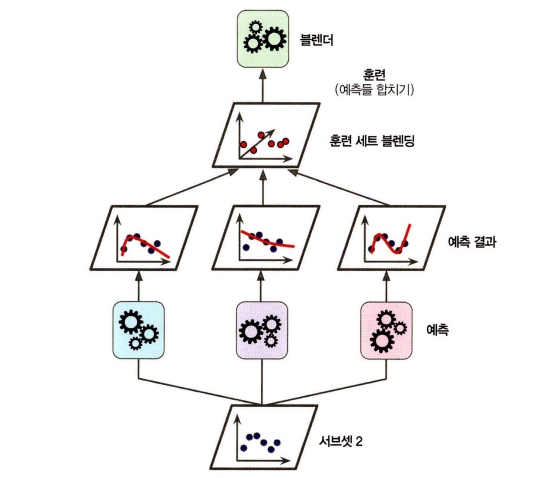